# Decision Trees on Amazon Fine Food Reviews

# Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

 1. Id
 2. ProductId - unique identifier for the product
 3. UserId - unqiue identifier for the user
 4. ProfileName
 5. HelpfulnessNumerator - number of users who found the review helpful
 6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
 7. Score - rating between 1 and 5
 8. Time - timestamp for the review
 9. Summary - brief summary of the review
 10.Text - text of the review

Objective:

* Given a review determine whether a review is positive or negative, by appling Decision Tree algorithm and deciding the best Feature generation technique for given problem. Also to report the metrics for each iteration. Time based splitting to be followed.


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# 1. Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [43]:
#import packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split
from sklearn import tree

In [44]:
# creating sql connection string
con = sqlite3.connect('../input/database.sqlite')

In [45]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews

WHERE Score != 3
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [46]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Time Based Splitting

In [47]:
import datetime

filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

sortedData = filtered_data.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

print(final.shape)
final.head()

(364173, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08 00:00:00,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25 00:00:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 00:00:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 00:00:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 00:00:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


# 3. Exploratory Data Analysis

**3.1 Data Cleaning: Deduplication**

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [48]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...



As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [49]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

**Observation:-**
* It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [50]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [51]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [52]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

**3.2 Text Preprocessing: Stemming, stop-word removal and Lemmatization.**

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
8. After which we collect the words used to describe positive and negative reviews

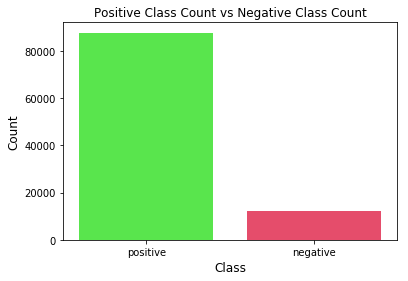

positive    87730
negative    12270
Name: Score, dtype: int64


In [53]:
# Data Sampling
final = final.iloc[:100000,:]

# Checking the number of positive and negative reviews
Class_Count  = final['Score'].value_counts()
plt.figure()
flatui = ["#15ff00", "#ff0033"]
sns.set_palette(flatui)
sns.barplot(Class_Count.index, Class_Count.values, alpha=0.8 )
plt.title('Positive Class Count vs Negative Class Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.show()
print(final['Score'].value_counts())

In [54]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Function to Remove HTML Tags
def cleanhtml(sentence):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner,"",sentence)
    return cleantext

# Function to clean punctuations and special characters

def cleanpunct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

# Initialize Stop words and PorterStemmer and Lemmetizer
stop = set(stopwords.words('english'))
sno = SnowballStemmer('english')

In [55]:
# Cleaning HTML and non-Alphanumeric characters from the review text
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1

In [57]:
final['CleanedText']=final_string
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08 00:00:00,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25 00:00:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 00:00:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 00:00:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 00:00:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


# Observations:-
    
* I've performed the following Data preprocessing.

    > Removed Stop-words
        
    > Removed any punctuations or limited set of special characters like , or . or # etc.
        
    > Snowball Stemming the word (The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form)
        
    > Converted the word to lowercase
        
* I've added a column called 'CleanedText' which displays the data after pre-processing of the review. So,Now we have 1000 reviews with 11 columns
    
* Out of 364k reviews, I 've sampled the data to 100k and applied Decision Tree Algorithm.

# 4. Applying Decision Tree

In [58]:
# Container to store the results
final_results = {}

In [92]:
# Function for Decision Trees
def runDT(X_tr_input,x_cv_input,y_tr_input,y_cv_input,VectorizationType):

        cv_scores = []
        depth = []
            
        j=0
        for i in range(1,15,2):
                dt = tree.DecisionTreeClassifier(max_depth=i)
                scores = cross_val_score(dt, X_tr_input, y_tr_input, cv=10, n_jobs=4)
                cv_scores.append(scores.mean())
                depth.append(i)
                print('For Depth = ', i,'CV Score = ', cv_scores[j])
                j+=1
        plt.plot(depth,cv_scores,'.-')
        plt.title('Tree Depth vs CV Scores')
        plt.ylabel('CV Scores')
        plt.xlabel('Tree Depth')
        plt.show()
        print(depth)
        print(cv_scores)
        print(depth[cv_scores.index(max(cv_scores))])
        
        # changing to misclassification error
        MSE = [1 - x for x in cv_scores]
                            
        # determining best alpha
        max_depth_optimum = depth[MSE.index(min(MSE))]                
        gini = tree.DecisionTreeClassifier(criterion='gini',max_depth= max_depth_optimum,random_state= 0)
        gini.fit(X_tr_input,y_tr_input)
        pred = gini.predict(x_cv_input)
        print('The Accuracy of Decision Tree Algorithm with tree depth = ',max_depth_optimum,'and ',VectorizationType,
        ' vectorization is: ',np.round((accuracy_score(y_cv_input, pred)*100),decimals = 2))
        final_results[VectorizationType] =accuracy_score(y_cv_input,pred)*100
        print("the misclassification error for each Tree Depth value is : ", np.round(MSE,3))
        
        # Plot Confusion Matrix, F1 Score, Recall, Precision and Classification Report
        from sklearn.metrics import confusion_matrix
        import scikitplot.metrics as skplt
        skplt.plot_confusion_matrix(y_cv_input,pred)
        plt.title('Confusion matrix of the classifier')
        plt.show()        
        print('F1 score for Decision Tree algorithm with tree depth =',max_depth_optimum,' is ' , np.round((f1_score(y_cv_input, pred,average= 'macro')*100),decimals = 2))
        print('Recall for Decision Tree agorithm with tree depth =',max_depth_optimum,' is ' , np.round((recall_score(y_cv_input, pred,average= 'macro')*100),decimals = 2))
        print('Precision for Decision Tree algorithm with tree depth =',max_depth_optimum,' is ' , np.round((precision_score(y_cv_input, pred,average= 'macro')*100),decimals = 2))
        print ('\n Classification report for Decision Tree algorithm with tree depth =',max_depth_optimum,' is \n ' , classification_report(y_cv_input,pred))

# 5. Feature Generation Techniques

**5.1 Using Bag of Words**

For Depth =  1 CV Score =  0.8769795981181312
For Depth =  3 CV Score =  0.8802042295540184
For Depth =  5 CV Score =  0.8857755332608022
For Depth =  7 CV Score =  0.8868163537786137
For Depth =  9 CV Score =  0.887550968538617
For Depth =  11 CV Score =  0.8880816807537695
For Depth =  13 CV Score =  0.8883674866730757


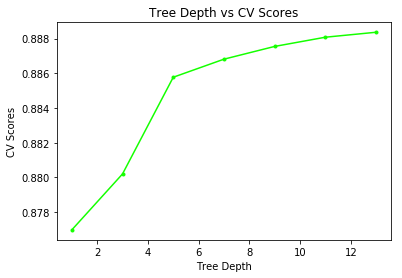

[1, 3, 5, 7, 9, 11, 13]
[0.8769795981181312, 0.8802042295540184, 0.8857755332608022, 0.8868163537786137, 0.887550968538617, 0.8880816807537695, 0.8883674866730757]
13
The Accuracy of Decision Tree Algorithm with tree depth =  13 and  Bag of Words  vectorization is:  88.72
the misclassification error for each Tree Depth value is :  [0.123 0.12  0.114 0.113 0.112 0.112 0.112]


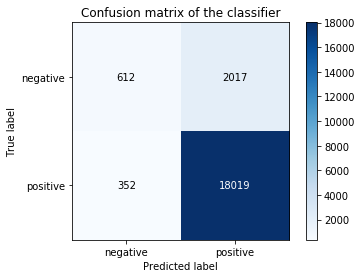

F1 score for Decision Tree algorithm with tree depth = 13  is  63.95
Recall for Decision Tree agorithm with tree depth = 13  is  60.68
Precision for Decision Tree algorithm with tree depth = 13  is  76.71

 Classification report for Decision Tree algorithm with tree depth = 13  is 
               precision    recall  f1-score   support

   negative       0.63      0.23      0.34      2629
   positive       0.90      0.98      0.94     18371

avg / total       0.87      0.89      0.86     21000



In [93]:
#Bag of Words
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['CleanedText'], final['Score'], random_state = 0,test_size = 0.3)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

vect = CountVectorizer().fit(X_tr)
X_tr_vectorized = vect.transform(X_tr)
x_cv_vectorized = vect.transform(X_cv)
runDT(X_tr_vectorized, x_cv_vectorized, y_tr, y_cv,'Bag of Words')

**Observations:-**

* I've applied Bag of Words (BOW) Feature Generation Technique to convert text to numeric vector.
    
* I've already sorted the data by Time, So here I've divided the data into three parts
            1. Train Data (49%)
            2. Data for Cross Validation (21%)
            3. Test Data (30 %)
            
* At Tree Depth '13' we got highest Accuarcy rate i.e 88.72%.
    
* In predictive analytics, a table of confusion (sometimes also called a confusion matrix), is a table with two rows and two columns that reports the number of false positives, false negatives, true positives, and true negatives. This allows more detailed analysis than mere proportion of correct classifications (accuracy).
    
           1. True Positive Rate (TPR)  = 612
           2. False Positive Rate (FPR) = 2017
           3. False Negative Rate (FNR) = 352
           4. True Negative Rate (TNR)  = 18019

**5.2 Using TF-IDF**

For Depth =  1 CV Score =  0.8769795981181312
For Depth =  3 CV Score =  0.8799797439204816
For Depth =  5 CV Score =  0.8860203895978709
For Depth =  7 CV Score =  0.8863672867359664
For Depth =  9 CV Score =  0.8863469368783414
For Depth =  11 CV Score =  0.8865918515108506
For Depth =  13 CV Score =  0.887000118903693


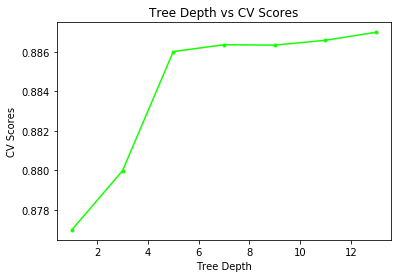

[1, 3, 5, 7, 9, 11, 13]
[0.8769795981181312, 0.8799797439204816, 0.8860203895978709, 0.8863672867359664, 0.8863469368783414, 0.8865918515108506, 0.887000118903693]
13
The Accuracy of Decision Tree Algorithm with tree depth =  13 and  TF-IDF  vectorization is:  88.58
the misclassification error for each Tree Depth value is :  [0.123 0.12  0.114 0.114 0.114 0.113 0.113]


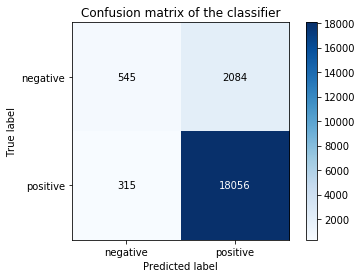

F1 score for Decision Tree algorithm with tree depth = 13  is  62.51
Recall for Decision Tree agorithm with tree depth = 13  is  59.51
Precision for Decision Tree algorithm with tree depth = 13  is  76.51

 Classification report for Decision Tree algorithm with tree depth = 13  is 
               precision    recall  f1-score   support

   negative       0.63      0.21      0.31      2629
   positive       0.90      0.98      0.94     18371

avg / total       0.86      0.89      0.86     21000



In [94]:
#TF-IDF
tf_idf_vec = TfidfVectorizer(min_df=5).fit(X_tr)
# Vectorizing the datsets
X_tr_vectorized = tf_idf_vec.transform(X_tr)
x_cv_vectorized = tf_idf_vec.transform(X_cv)

runDT(X_tr_vectorized,x_cv_vectorized,y_tr,y_cv,'TF-IDF')

**Observations:-**

* I've applied TF-IDF Feature Generation Technique to convert text to numeric vector.
    
* I've already sorted the data by Time, So here I've divided the data into three parts
            1. Train Data (49%)
            2. Data for Cross Validation (21%)
            3. Test Data (30 %)
            
* At Tree Depth '13' we got highest Accuarcy rate i.e 88.58%.
    
* In predictive analytics, a table of confusion (sometimes also called a confusion matrix), is a table with two rows and two columns that reports the number of false positives, false negatives, true positives, and true negatives. This allows more detailed analysis than mere proportion of correct classifications (accuracy).
    
           1. True Positive Rate (TPR)  = 545
           2. False Positive Rate (FPR) = 2084
           3. False Negative Rate (FNR) = 315
           4. True Negative Rate (TNR)  = 18056

**5.3 Using Word2Vec**

In [80]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    
words = list(w2v_model.wv.vocab)
print(len(words))

19060


For Depth =  1 CV Score =  0.8763285760370263
For Depth =  3 CV Score =  0.8763285760370263
For Depth =  5 CV Score =  0.8798571536303209
For Depth =  7 CV Score =  0.8795572332242001
For Depth =  9 CV Score =  0.8733857025454809
For Depth =  11 CV Score =  0.8667998249093258
For Depth =  13 CV Score =  0.8586712901151576


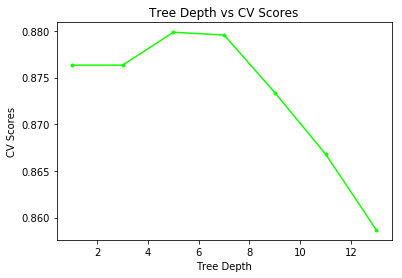

[1, 3, 5, 7, 9, 11, 13]
[0.8763285760370263, 0.8763285760370263, 0.8798571536303209, 0.8795572332242001, 0.8733857025454809, 0.8667998249093258, 0.8586712901151576]
5
The Accuracy of Decision Tree Algorithm with tree depth =  5 and  Word2Vec  vectorization is:  88.25
the misclassification error for each Tree Depth value is :  [0.124 0.124 0.12  0.12  0.127 0.133 0.141]


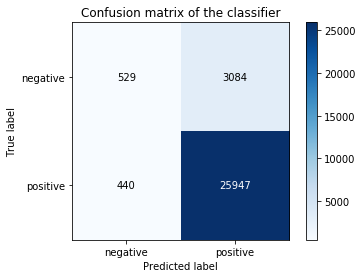

F1 score for Decision Tree algorithm with tree depth = 5  is  58.37
Recall for Decision Tree agorithm with tree depth = 5  is  56.49
Precision for Decision Tree algorithm with tree depth = 5  is  71.98

 Classification report for Decision Tree algorithm with tree depth = 5  is 
               precision    recall  f1-score   support

   negative       0.55      0.15      0.23      3613
   positive       0.89      0.98      0.94     26387

avg / total       0.85      0.88      0.85     30000



In [95]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
# split the train data set into cross validation train and cross validation test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(sent_vectors, final['Score'], random_state = 0,test_size = 0.3)

#Decision Tree Algorithm on Word2Vec
runDT(X_1, X_test, y_1, y_test,'Word2Vec')

**Observations:-**

* I've applied Word2Vec Feature Generation Technique to convert text to numeric vector.
    
* I've already sorted the data by Time, So here I've divided the data into three parts
            1. Train Data (49%)
            2. Data for Cross Validation (21%)
            3. Test Data (30 %)
            
* At Tree Depth '5' we got highest Accuarcy rate i.e 88.25%.
    
* In predictive analytics, a table of confusion (sometimes also called a confusion matrix), is a table with two rows and two columns that reports the number of false positives, false negatives, true positives, and true negatives. This allows more detailed analysis than mere proportion of correct classifications (accuracy).
    
           1. True Positive Rate (TPR)  = 529
           2. False Positive Rate (FPR) = 3084
           3. False Negative Rate (FNR) = 440
           4. True Negative Rate (TNR)  = 25947

** 5.4 Using TF-IDF  Average Weighted Word2Vec**

For Depth =  1 CV Score =  0.8763285760370263
For Depth =  3 CV Score =  0.8763285760370263
For Depth =  5 CV Score =  0.8763285760370263
For Depth =  7 CV Score =  0.8763285760370263
For Depth =  9 CV Score =  0.8763285760370263
For Depth =  11 CV Score =  0.8763285760370263
For Depth =  13 CV Score =  0.8763285760370263


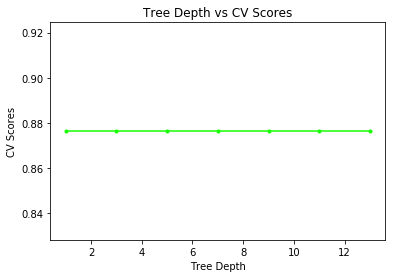

[1, 3, 5, 7, 9, 11, 13]
[0.8763285760370263, 0.8763285760370263, 0.8763285760370263, 0.8763285760370263, 0.8763285760370263, 0.8763285760370263, 0.8763285760370263]
1
The Accuracy of Decision Tree Algorithm with tree depth =  1 and  TF-IDF Average Weighted Word2Vec  vectorization is:  87.96
the misclassification error for each Tree Depth value is :  [0.124 0.124 0.124 0.124 0.124 0.124 0.124]


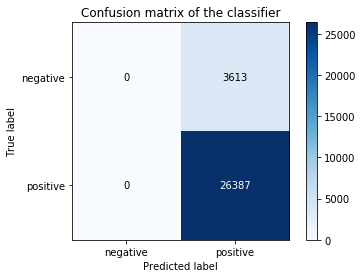

F1 score for Decision Tree algorithm with tree depth = 1  is  46.8
Recall for Decision Tree agorithm with tree depth = 1  is  50.0
Precision for Decision Tree algorithm with tree depth = 1  is  43.98

 Classification report for Decision Tree algorithm with tree depth = 1  is 
               precision    recall  f1-score   support

   negative       0.00      0.00      0.00      3613
   positive       0.88      1.00      0.94     26387

avg / total       0.77      0.88      0.82     30000



In [96]:
tfidf_feat = tf_idf_vec.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = vect_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    
    try:
        sent_vec /= weight_sum
    except:
        pass
    
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
#X_tr_vec = np.nan_to_num(X_tr)
#X_cv_vec = np.nan_to_num(X_cv)

#Splitting into TRaining and Testing Set, and using only Training set for Word2Vec Training
X_1, X_test, y_1, y_test = cross_validation.train_test_split(tfidf_sent_vectors, final['Score'], random_state = 0,test_size = 0.3)

X_1_tr = np.nan_to_num(X_1)
X_test_cv = np.nan_to_num(X_test)

#Decision Tree Algorithm on Word2Vec
runDT(X_1_tr, X_test_cv, y_1, y_test,'TF-IDF Average Weighted Word2Vec')

**Observations:-**

* I've applied TF-IDF Avg Weighted Word2Vec Feature Generation Technique to convert text to numeric vector.
    
* I've already sorted the data by Time, So here I've divided the data into three parts
            1. Train Data (49%)
            2. Data for Cross Validation (21%)
            3. Test Data (30 %)
            
* At Tree Depth '1' we got highest Accuarcy rate i.e 87.96%.
    
* In predictive analytics, a table of confusion (sometimes also called a confusion matrix), is a table with two rows and two columns that reports the number of false positives, false negatives, true positives, and true negatives. This allows more detailed analysis than mere proportion of correct classifications (accuracy).
    
           1. True Positive Rate (TPR)  = 0
           2. False Positive Rate (FPR) = 3613
           3. False Negative Rate (FNR) = 0
           4. True Negative Rate (TNR)  = 26387

# 6. Decision Tree on Featurization Techniques - Tabular Result

In [109]:
import pandas as pd
print("Decision Tree on Featurization Techniques")
dataframe = pd.DataFrame(
{
    "1. Model": ['BOW','TF-IDF','WORD2VEC','AVG W2V'],
    "2. Tree Depth": [13,13,5,1],
    "3. Test Accuracy (%)": [88.72,88.58,88.25,87.96],
    "4. F1 Score (%)": [63.95,62.51,58.37,46.8],
    "5. Recall (%)": [60.68,59.51,56.49,50,],
    "6. Precision (%)": [76.71,76.51,71.98,43.98],
    "7. Train Error (%)": [11.2,11.3,12,12.4],    
}

)
dataframe

Decision Tree on Featurization Techniques


,1. Model,2. Tree Depth,3. Test Accuracy (%),4. F1 Score (%),5. Recall (%),6. Precision (%),7. Train Error (%)
0,BOW,13,88.72,63.95,60.68,76.71,11.2
1,TF-IDF,13,88.58,62.51,59.51,76.51,11.3
2,WORD2VEC,5,88.25,58.37,56.49,71.98,12.0
3,AVG W2V,1,87.96,46.80,50.00,43.98,12.4


# 7. Conclusion

* The result of feature generation techniques and machine learning algorithms vary by application. But by comparing the accuracy of all 4 developed models, Decision Tree with BOW feature generation technique gives accuracy more than 88% which is the best to predict the polarity of reviews among all models. The best Tree Depth value is 13.